In [1]:
!pip install wandb -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 49.8 MB/s eta 0:00:00


In [1]:
import wandb

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m027 (da24m027-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "batch_size": {"values": [16, 32, 64]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        "weights": {"values": ["random", "Xavier"]},
        "learning_rate": {"values": [0.001, 0.0001]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "loss_type": {"values": ["mse", "cross_entropy"]},
    },
}

In [4]:
import pprint
pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'ReLU']},
                'batch_size': {'values': [16, 32, 64]},
                'epochs': {'values': [5, 10]},
                'hidden_layers': {'values': [3, 4, 5]},
                'hidden_size': {'values': [32, 64, 128]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'loss_type': {'values': ['mse', 'cross_entropy']},
                'optimizer': {'values': ['sgd',
                                         'momentum',
                                         'nesterov',
                                         'rmsprop',
                                         'adam',
                                         'nadam']},
                'weight_decay': {'values': [0, 0.0005, 0.5]},
                'weights': {'values': ['random', 'Xavier']}}}


In [5]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment1")

Create sweep with ID: xy966igu
Sweep URL: https://wandb.ai/da24m027-indian-institute-of-technology-madras/DA6401_Assignment1/sweeps/xy966igu


In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from keras.datasets import fashion_mnist

def preprocess_data(X_train, y_train, X_test, y_test):
    """
    Normalize and reshape dataset.
    """
    X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize
    X_train, X_test = X_train.reshape(-1, 784), X_test.reshape(-1, 784)  # Flatten images

    # One-hot encoding
    y_train_encoded = np.zeros((y_train.size, 10))
    y_train_encoded[np.arange(y_train.size), y_train] = 1

    y_test_encoded = np.zeros((y_test.size, 10))
    y_test_encoded[np.arange(y_test.size), y_test] = 1

    return X_train, y_train_encoded, X_test, y_test_encoded

def evaluate(model, X_test, y_test):
    """
    Evaluate model accuracy.
    """
    y_pred = model.forward(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    accuracy = np.mean(y_pred_labels == y_true_labels)
    return accuracy

def calculate_loss(y_true, y_pred, loss_type):
  if loss_type == 'mse':
    return np.mean(np.square(y_true - y_pred))
  elif loss_type == 'cross_entropy':
    #Small epsilon to prevent log(0)
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    return -np.mean(y_true * np.log(y_pred))

def calculate_accuracy(y_true, y_pred):
  predicted_classes = np.argmax(y_pred, axis=1)
  true_classes = np.argmax(y_true, axis=1)
  return np.mean(predicted_classes == true_classes)

In [7]:
import numpy as np
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, hidden_size, output_size, activation="ReLU", init_method = "random", loss_type = "mse"):
        self.layers = [input_size] + [hidden_size] * hidden_layers + [output_size]
        self.init_method = init_method
        self.weights = self.initialize_weights()
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.activation = activation
        self.loss_type = loss_type

    def initialize_weights(self):
        weights = []
        for i in range(len(self.layers) - 1):
            if self.init_method == "Xavier":
                limit = np.sqrt(1 / self.layers[i])
                weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
        return weights

    def activation_func(self, x, is_output=False):
        if is_output and self.loss_type == "cross_entropy":
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        if self.activation == "ReLU":
            return np.maximum(0, x)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif self.activation == "tanh":
            return np.tanh(x)

    def forward(self, X):
        self.a = [X]
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(self.a[-1], W) + b
            # Check if this is the output layer
            is_output = (i == len(self.weights) - 1)
            self.a.append(self.activation_func(z, is_output=is_output))
        return self.a[-1]

In [8]:
import numpy as np

class Backpropagation:
    def __init__(self, model, optimizer="sgd", learning_rate=0.01, momentum=0.9, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.0):
        """
        Initialize the backpropagation optimizer.
        :param model: NeuralNetwork model instance
        :param optimizer: Optimization algorithm ('sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam')
        :param learning_rate: Learning rate for weight updates
        :param momentum: Momentum factor for momentum-based optimizers
        :param beta: Decay factor for RMSprop
        :param beta1: First moment decay rate (Adam, Nadam)
        :param beta2: Second moment decay rate (Adam, Nadam)
        :param epsilon: Small value to prevent division by zero
        :param weight_decay: L2 Regularisation
        """
        self.model = model
        self.optimizer = optimizer
        self.lr = learning_rate
        self.momentum = momentum
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay

        # Initialize velocity (for Momentum and Nesterov)
        self.velocities = [np.zeros_like(W) for W in model.weights]

        # Initialize moving averages (for Adam, Nadam, RMSprop)
        self.m = [np.zeros_like(W) for W in model.weights]
        self.v = [np.zeros_like(W) for W in model.weights]
        self.t = 0  # Time step for Adam/Nadam

    def backward(self, y_true, y_pred):
        """
        Perform backward pass to compute gradients.
        :param y_true: True labels
        :param y_pred: Predicted output
        :return: Gradients for each layer
        """
        gradients = []
        delta = y_pred - y_true #Same for mse and cross entropy as softmax outputs is handled in feedforward

        for i in reversed(range(len(self.model.weights))):
            grad_W = np.dot(self.model.a[i].T, delta) / y_true.shape[0]
            grad_W += self.weight_decay * self.model.weights[i]  # Apply L2 regularization
            gradients.insert(0, grad_W)

            if i > 0:
                if self.model.activation == "ReLU":
                    delta = np.dot(delta, self.model.weights[i].T) * (self.model.a[i] > 0)
                elif self.model.activation == "sigmoid":
                    delta = np.dot(delta, self.model.weights[i].T) * (self.model.a[i] * (1 - self.model.a[i]))
                elif self.model.activation == "tanh":
                    delta = np.dot(delta, self.model.weights[i].T) * (1 - self.model.a[i]**2)


        return gradients

    def update_weights(self, gradients):
        """
        Updates the model weights using the selected optimizer.
        :param gradients: List of gradient matrices for each layer
        """
        self.t += 1  # Increment time step for Adam/Nadam

        for i in range(len(self.model.weights)):
            grad = gradients[i] + self.weight_decay * self.model.weights[i]  # Apply L2 regularization

            if self.optimizer == "sgd":
                # Stochastic Gradient Descent (SGD)
                self.model.weights[i] -= self.lr * grad

            elif self.optimizer == "momentum":
                # Momentum-Based Gradient Descent
                self.velocities[i] = self.momentum * self.velocities[i] - self.lr * grad
                self.model.weights[i] += self.velocities[i]

            elif self.optimizer == "nesterov":
                # Nesterov Accelerated Gradient Descent
                prev_velocity = self.velocities[i]
                self.velocities[i] = self.momentum * self.velocities[i] - self.lr * grad
                self.model.weights[i] += -self.momentum * prev_velocity + (1 + self.momentum) * self.velocities[i]

            elif self.optimizer == "rmsprop":
                # RMSprop
                self.v[i] = self.beta * self.v[i] + (1 - self.beta) * (grad ** 2)
                self.model.weights[i] -= self.lr * grad / (np.sqrt(self.v[i]) + self.epsilon)

            elif self.optimizer == "adam":
                # Adam (Adaptive Moment Estimation)
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

                # Bias correction
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)

                self.model.weights[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

            elif self.optimizer == "nadam":
                # Nadam (Nesterov-accelerated Adam)
                m_hat = (self.beta1 * self.m[i] + (1 - self.beta1) * grad) / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)

                self.model.weights[i] -= self.lr * (self.beta1 * m_hat + (1 - self.beta1) * grad / (1 - self.beta1 ** self.t)) / (np.sqrt(v_hat) + self.epsilon)

            else:
                raise ValueError(f"Optimizer '{self.optimizer}' is not recognized.")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Sample Images for each Class :


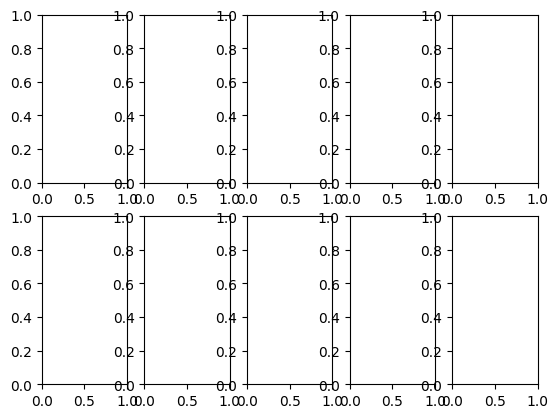

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import wandb

# load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Sample Images for each Class :")
class_list=list()
wandb.init(project="DA6401_Assignment1")
for i in range(10):
  plt.subplot(2,5,i+1)
  for j in range(len(y_train)):
    if y_train[j] == i :
        wandb.log({"img": [wandb.Image(x_train[j], caption=class_type[y_train[j]])]})
        class_list.append(class_type[y_train[j]])
        break

In [9]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config
    wandb.run.name = "e_{}_hl_{}_hs_{}_lr_{}_opt_{}_bs_{}_init_{}_ac_{}_wd_{}_loss_{}".format(config.epochs,\
                                                                      config.hidden_layers,\
                                                                      config.hidden_size,\
                                                                      config.learning_rate,\
                                                                      config.optimizer,\
                                                                      config.batch_size,\
                                                                      config.weights,\
                                                                      config.activation,\
                                                                      config.weight_decay,\
                                                                      config.loss_type)
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

    val_size = int(0.1 * len(X_train))
    X_val, y_val = X_train[:val_size], y_train[:val_size]
    X_train, y_train = X_train[val_size:], y_train[val_size:]

    model = NeuralNetwork(input_size=784, hidden_layers=config.hidden_layers, hidden_size=config.hidden_size, output_size=10, activation=config.activation, init_method=config.weights, loss_type = config.loss_type)
    backprop = Backpropagation(model, optimizer=config.optimizer, learning_rate=config.learning_rate, weight_decay=config.weight_decay)

    for epoch in range(config.epochs):
      loss = 0
      for i in range(0, len(X_train), config.batch_size):
        batch_X = X_train[i:i + config.batch_size]
        batch_y = y_train[i:i + config.batch_size]

        # Forward & Backward pass
        y_pred = model.forward(batch_X)
        gradients = backprop.backward(batch_y, y_pred)
        backprop.update_weights(gradients)

        # Compute loss
        loss += calculate_loss(batch_y, y_pred, config.loss_type)

      loss /= len(X_train)
      wandb.log({"epoch": epoch+1, "loss": loss})

      # Validate model
      val_pred = model.forward(X_val)
      val_loss = calculate_loss(y_val, val_pred, config.loss_type)
      val_accuracy = calculate_accuracy(y_val, val_pred)
      wandb.log({"epoch": epoch+1, "val_loss": val_loss, "val_accuracy": val_accuracy})

      print(f"Epoch {epoch+1}/{config.epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [10]:
wandb.agent(sweep_id, train, count=100)

wandb: Agent Starting Run: 8glvykow with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0965
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0965
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0963


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁██▁▁▁▁▁
val_loss,▁▁▁███████
epoch,10
loss,0.00156
val_accuracy,0.09633
val_loss,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1vna9pz3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.0072
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: tjgpxjh2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0021, Val Loss: 0.0532, Val Accuracy: 0.6670
Epoch 2/5, Loss: 0.0015, Val Loss: 0.0441, Val Accuracy: 0.7262
Epoch 3/5, Loss: 0.0013, Val Loss: 0.0389, Val Accuracy: 0.7762
Epoch 4/5, Loss: 0.0012, Val Loss: 0.0365, Val Accuracy: 0.7855
Epoch 5/5, Loss: 0.0011, Val Loss: 0.0350, Val Accuracy: 0.7888


epoch,▁▁▃▃▅▅▆▆██
loss,█▄▂▁▁
val_accuracy,▁▄▇██
val_loss,█▄▂▂▁
epoch,5
loss,0.00113
val_accuracy,0.78883
val_loss,0.03502


wandb: Agent Starting Run: ojvi88yi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0011, Val Loss: 0.0283, Val Accuracy: 0.8320
Epoch 2/10, Loss: 0.0009, Val Loss: 0.0268, Val Accuracy: 0.8385
Epoch 3/10, Loss: 0.0008, Val Loss: 0.0257, Val Accuracy: 0.8423
Epoch 4/10, Loss: 0.0008, Val Loss: 0.0252, Val Accuracy: 0.8442
Epoch 5/10, Loss: 0.0008, Val Loss: 0.0249, Val Accuracy: 0.8443
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0248, Val Accuracy: 0.8452
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0246, Val Accuracy: 0.8442
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0245, Val Accuracy: 0.8427
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0243, Val Accuracy: 0.8440
Epoch 10/10, Loss: 0.0007, Val Loss: 0.0242, Val Accuracy: 0.8443


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇██▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
loss,0.00072
val_accuracy,0.84433
val_loss,0.02421


wandb: Agent Starting Run: g8a7rvu8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0185, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 2/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 3/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 4/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 5/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 6/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 7/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 8/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 9/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990
Epoch 10/10, Loss: 0.0184, Val Loss: 1.1791, Val Accuracy: 0.0990


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.01844
val_accuracy,0.099
val_loss,1.17913


wandb: Agent Starting Run: 3fy1hnga with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0688
Epoch 2/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0690
Epoch 3/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0780
Epoch 4/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▄███████
val_loss,▁█████████
epoch,10
loss,0.0072
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: hynianys with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 2/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 3/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 4/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 5/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 6/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 7/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1803
Epoch 8/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,███████▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00313
val_accuracy,0.09333
val_loss,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tt6vjjrx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0029, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 3/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 4/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 5/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0028, Val Loss: 0.0900, Val Accuracy: 0.0973


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
loss,0.00281
val_accuracy,0.09733
val_loss,0.09004


wandb: Agent Starting Run: wivea0xs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0011, Val Loss: 0.0567, Val Accuracy: 0.6483
Epoch 2/10, Loss: 0.0008, Val Loss: 0.0489, Val Accuracy: 0.6885
Epoch 3/10, Loss: 0.0007, Val Loss: 0.0447, Val Accuracy: 0.7257
Epoch 4/10, Loss: 0.0007, Val Loss: 0.0411, Val Accuracy: 0.7595
Epoch 5/10, Loss: 0.0006, Val Loss: 0.0385, Val Accuracy: 0.7767
Epoch 6/10, Loss: 0.0006, Val Loss: 0.0366, Val Accuracy: 0.7882
Epoch 7/10, Loss: 0.0006, Val Loss: 0.0352, Val Accuracy: 0.8007
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0341, Val Accuracy: 0.8093
Epoch 9/10, Loss: 0.0005, Val Loss: 0.0332, Val Accuracy: 0.8178
Epoch 10/10, Loss: 0.0005, Val Loss: 0.0324, Val Accuracy: 0.8208


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
loss,0.00052
val_accuracy,0.82083
val_loss,0.03245


wandb: Agent Starting Run: 4necdbgi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 2/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 3/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 4/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 5/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 6/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 7/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 8/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 9/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 10/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.0036
val_accuracy,0.10283
val_loss,0.23026


wandb: Agent Starting Run: gkss8v9s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0492, Val Accuracy: 0.8250
Epoch 2/10, Loss: 0.0007, Val Loss: 0.0447, Val Accuracy: 0.8398
Epoch 3/10, Loss: 0.0006, Val Loss: 0.0421, Val Accuracy: 0.8453
Epoch 4/10, Loss: 0.0006, Val Loss: 0.0409, Val Accuracy: 0.8485
Epoch 5/10, Loss: 0.0006, Val Loss: 0.0412, Val Accuracy: 0.8467
Epoch 6/10, Loss: 0.0006, Val Loss: 0.0399, Val Accuracy: 0.8527
Epoch 7/10, Loss: 0.0005, Val Loss: 0.0384, Val Accuracy: 0.8590
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0385, Val Accuracy: 0.8563
Epoch 9/10, Loss: 0.0005, Val Loss: 0.0385, Val Accuracy: 0.8552
Epoch 10/10, Loss: 0.0005, Val Loss: 0.0373, Val Accuracy: 0.8612


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▅▆█▇▇█
val_loss,█▅▄▃▃▃▂▂▂▁
epoch,10
loss,0.00051
val_accuracy,0.86117
val_loss,0.03732


wandb: Agent Starting Run: wtn21cj9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 2/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 3/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 4/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 5/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 6/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 7/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 8/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 9/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057
Epoch 10/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0057


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.0036
val_accuracy,0.00567
val_loss,0.23026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qmf9xuo5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1575
Epoch 2/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1607
Epoch 3/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1612
Epoch 4/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1613
Epoch 5/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1613


epoch,▁▁▃▃▅▅▆▆██
loss,▁████
val_accuracy,▁▇███
val_loss,▁████
epoch,5
loss,0.00156
val_accuracy,0.16133
val_loss,0.1


wandb: Agent Starting Run: m1mgmwut with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


<ipython-input-8-234fc85004ae>:107: RuntimeWarning: overflow encountered in divide
  self.model.weights[i] -= self.lr * (self.beta1 * m_hat + (1 - self.beta1) * grad / (1 - self.beta1 ** self.t)) / (np.sqrt(v_hat) + self.epsilon)


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: 7zvie6h6 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0033
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,█▁████████
val_loss,▁█████████
epoch,10
loss,0.00156
val_accuracy,0.09333
val_loss,0.1


wandb: Agent Starting Run: sp6mk4w3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0034, Val Loss: 0.0702, Val Accuracy: 0.7510
Epoch 2/10, Loss: 0.0020, Val Loss: 0.0562, Val Accuracy: 0.8040
Epoch 3/10, Loss: 0.0017, Val Loss: 0.0503, Val Accuracy: 0.8250
Epoch 4/10, Loss: 0.0015, Val Loss: 0.0470, Val Accuracy: 0.8378
Epoch 5/10, Loss: 0.0015, Val Loss: 0.0449, Val Accuracy: 0.8460
Epoch 6/10, Loss: 0.0014, Val Loss: 0.0435, Val Accuracy: 0.8503
Epoch 7/10, Loss: 0.0014, Val Loss: 0.0425, Val Accuracy: 0.8525
Epoch 8/10, Loss: 0.0013, Val Loss: 0.0417, Val Accuracy: 0.8545
Epoch 9/10, Loss: 0.0013, Val Loss: 0.0410, Val Accuracy: 0.8553
Epoch 10/10, Loss: 0.0013, Val Loss: 0.0403, Val Accuracy: 0.8577


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
loss,0.00127
val_accuracy,0.85767
val_loss,0.04034


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uy3f08nm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0272, Val Accuracy: 0.8373
Epoch 2/10, Loss: 0.0008, Val Loss: 0.0259, Val Accuracy: 0.8423
Epoch 3/10, Loss: 0.0008, Val Loss: 0.0252, Val Accuracy: 0.8460
Epoch 4/10, Loss: 0.0008, Val Loss: 0.0246, Val Accuracy: 0.8468
Epoch 5/10, Loss: 0.0007, Val Loss: 0.0241, Val Accuracy: 0.8487
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0237, Val Accuracy: 0.8503
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0234, Val Accuracy: 0.8502
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0231, Val Accuracy: 0.8512
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0230, Val Accuracy: 0.8512
Epoch 10/10, Loss: 0.0007, Val Loss: 0.0229, Val Accuracy: 0.8530


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇█
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
loss,0.00068
val_accuracy,0.853
val_loss,0.02287


wandb: Agent Starting Run: q5s81zrm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 2/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 3/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 4/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 5/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 6/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 7/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 8/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 9/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545
Epoch 10/10, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0545


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00313
val_accuracy,0.0545
val_loss,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tbgiqck7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0008, Val Loss: 0.0358, Val Accuracy: 0.7698
Epoch 2/10, Loss: 0.0005, Val Loss: 0.0301, Val Accuracy: 0.8143
Epoch 3/10, Loss: 0.0005, Val Loss: 0.0280, Val Accuracy: 0.8330
Epoch 4/10, Loss: 0.0004, Val Loss: 0.0267, Val Accuracy: 0.8425
Epoch 5/10, Loss: 0.0004, Val Loss: 0.0258, Val Accuracy: 0.8460
Epoch 6/10, Loss: 0.0004, Val Loss: 0.0252, Val Accuracy: 0.8500
Epoch 7/10, Loss: 0.0004, Val Loss: 0.0247, Val Accuracy: 0.8528
Epoch 8/10, Loss: 0.0004, Val Loss: 0.0243, Val Accuracy: 0.8575
Epoch 9/10, Loss: 0.0004, Val Loss: 0.0240, Val Accuracy: 0.8588
Epoch 10/10, Loss: 0.0004, Val Loss: 0.0237, Val Accuracy: 0.8597


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
loss,0.00037
val_accuracy,0.85967
val_loss,0.02371


wandb: Agent Starting Run: yvehh7jf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0019, Val Loss: 0.0755, Val Accuracy: 0.7178
Epoch 2/10, Loss: 0.0011, Val Loss: 0.0605, Val Accuracy: 0.7882
Epoch 3/10, Loss: 0.0009, Val Loss: 0.0542, Val Accuracy: 0.8117
Epoch 4/10, Loss: 0.0008, Val Loss: 0.0509, Val Accuracy: 0.8247
Epoch 5/10, Loss: 0.0008, Val Loss: 0.0487, Val Accuracy: 0.8332
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0470, Val Accuracy: 0.8402
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0457, Val Accuracy: 0.8440
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0446, Val Accuracy: 0.8465
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0437, Val Accuracy: 0.8492
Epoch 10/10, Loss: 0.0007, Val Loss: 0.0430, Val Accuracy: 0.8525


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
loss,0.00068
val_accuracy,0.8525
val_loss,0.04301


wandb: Agent Starting Run: ia8j8tue with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


<ipython-input-8-234fc85004ae>:52: RuntimeWarning: invalid value encountered in multiply
  delta = np.dot(delta, self.model.weights[i].T) * (self.model.a[i] > 0)
<ipython-input-6-0ca641ebb121>:35: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y_true - y_pred))


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: f5lnabmn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0017, Val Loss: 0.0773, Val Accuracy: 0.7118
Epoch 2/10, Loss: 0.0011, Val Loss: 0.0673, Val Accuracy: 0.7588
Epoch 3/10, Loss: 0.0010, Val Loss: 0.0606, Val Accuracy: 0.7802
Epoch 4/10, Loss: 0.0009, Val Loss: 0.0560, Val Accuracy: 0.7997
Epoch 5/10, Loss: 0.0008, Val Loss: 0.0526, Val Accuracy: 0.8133
Epoch 6/10, Loss: 0.0008, Val Loss: 0.0501, Val Accuracy: 0.8230
Epoch 7/10, Loss: 0.0008, Val Loss: 0.0477, Val Accuracy: 0.8322
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0455, Val Accuracy: 0.8412
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0437, Val Accuracy: 0.8485
Epoch 10/10, Loss: 0.0007, Val Loss: 0.0422, Val Accuracy: 0.8547


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
loss,0.00066
val_accuracy,0.85467
val_loss,0.04217


wandb: Agent Starting Run: j0jkpjv0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0011, Val Loss: 0.0466, Val Accuracy: 0.8362
Epoch 2/10, Loss: 0.0007, Val Loss: 0.0433, Val Accuracy: 0.8392
Epoch 3/10, Loss: 0.0006, Val Loss: 0.0416, Val Accuracy: 0.8465
Epoch 4/10, Loss: 0.0006, Val Loss: 0.0393, Val Accuracy: 0.8563
Epoch 5/10, Loss: 0.0006, Val Loss: 0.0398, Val Accuracy: 0.8527
Epoch 6/10, Loss: 0.0006, Val Loss: 0.0392, Val Accuracy: 0.8537
Epoch 7/10, Loss: 0.0005, Val Loss: 0.0390, Val Accuracy: 0.8538
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0372, Val Accuracy: 0.8617
Epoch 9/10, Loss: 0.0005, Val Loss: 0.0385, Val Accuracy: 0.8540
Epoch 10/10, Loss: 0.0005, Val Loss: 0.0384, Val Accuracy: 0.8550


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▇▆▆▆█▆▆
val_loss,█▆▄▃▃▃▂▁▂▂
epoch,10
loss,0.00052
val_accuracy,0.855
val_loss,0.03842


wandb: Agent Starting Run: tsr31na7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0257, Val Accuracy: 0.8473
Epoch 2/10, Loss: 0.0008, Val Loss: 0.0250, Val Accuracy: 0.8490
Epoch 3/10, Loss: 0.0008, Val Loss: 0.0249, Val Accuracy: 0.8553
Epoch 4/10, Loss: 0.0007, Val Loss: 0.0240, Val Accuracy: 0.8598
Epoch 5/10, Loss: 0.0007, Val Loss: 0.0235, Val Accuracy: 0.8597
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0240, Val Accuracy: 0.8560
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0226, Val Accuracy: 0.8652
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0223, Val Accuracy: 0.8652
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0224, Val Accuracy: 0.8658
Epoch 10/10, Loss: 0.0007, Val Loss: 0.0228, Val Accuracy: 0.8608


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▄▆▆▄███▆
val_loss,█▇▆▄▃▄▂▁▁▂
epoch,10
loss,0.0007
val_accuracy,0.86083
val_loss,0.0228


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: poihedgz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uume7iqp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0015, Val Loss: 0.0894, Val Accuracy: 0.2312
Epoch 2/5, Loss: 0.0014, Val Loss: 0.0840, Val Accuracy: 0.3652
Epoch 3/5, Loss: 0.0013, Val Loss: 0.0802, Val Accuracy: 0.4917
Epoch 4/5, Loss: 0.0012, Val Loss: 0.0770, Val Accuracy: 0.5293
Epoch 5/5, Loss: 0.0012, Val Loss: 0.0743, Val Accuracy: 0.5692


epoch,▁▁▃▃▅▅▆▆██
loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,5
loss,0.00119
val_accuracy,0.56917
val_loss,0.07435


wandb: Agent Starting Run: fip3g1dz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0454, Val Accuracy: 0.8403
Epoch 2/10, Loss: 0.0007, Val Loss: 0.0425, Val Accuracy: 0.8530
Epoch 3/10, Loss: 0.0006, Val Loss: 0.0419, Val Accuracy: 0.8542
Epoch 4/10, Loss: 0.0006, Val Loss: 0.0421, Val Accuracy: 0.8523
Epoch 5/10, Loss: 0.0006, Val Loss: 0.0413, Val Accuracy: 0.8575
Epoch 6/10, Loss: 0.0006, Val Loss: 0.0412, Val Accuracy: 0.8558
Epoch 7/10, Loss: 0.0006, Val Loss: 0.0414, Val Accuracy: 0.8558
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0413, Val Accuracy: 0.8542
Epoch 9/10, Loss: 0.0005, Val Loss: 0.0416, Val Accuracy: 0.8550
Epoch 10/10, Loss: 0.0005, Val Loss: 0.0420, Val Accuracy: 0.8523


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▆█▇▇▇▇▆
val_loss,█▃▂▃▁▁▁▁▂▂
epoch,10
loss,0.00052
val_accuracy,0.85233
val_loss,0.04202


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g7z8z4b8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: 6i55a3nh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0027, Val Loss: 0.0802, Val Accuracy: 0.5353
Epoch 2/10, Loss: 0.0024, Val Loss: 0.0729, Val Accuracy: 0.5895
Epoch 3/10, Loss: 0.0022, Val Loss: 0.0671, Val Accuracy: 0.6130
Epoch 4/10, Loss: 0.0020, Val Loss: 0.0628, Val Accuracy: 0.6250
Epoch 5/10, Loss: 0.0019, Val Loss: 0.0591, Val Accuracy: 0.6408
Epoch 6/10, Loss: 0.0018, Val Loss: 0.0560, Val Accuracy: 0.6470
Epoch 7/10, Loss: 0.0017, Val Loss: 0.0538, Val Accuracy: 0.6573
Epoch 8/10, Loss: 0.0017, Val Loss: 0.0523, Val Accuracy: 0.6625
Epoch 9/10, Loss: 0.0016, Val Loss: 0.0512, Val Accuracy: 0.6655
Epoch 10/10, Loss: 0.0016, Val Loss: 0.0502, Val Accuracy: 0.6668


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
loss,0.00159
val_accuracy,0.66683
val_loss,0.05021


wandb: Agent Starting Run: doq8xdty with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0031, Val Loss: 0.0997, Val Accuracy: 0.1235
Epoch 2/10, Loss: 0.0031, Val Loss: 0.0992, Val Accuracy: 0.1045
Epoch 3/10, Loss: 0.0031, Val Loss: 0.0975, Val Accuracy: 0.1010
Epoch 4/10, Loss: 0.0030, Val Loss: 0.0928, Val Accuracy: 0.1088
Epoch 5/10, Loss: 0.0029, Val Loss: 0.0907, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0028, Val Loss: 0.0903, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0028, Val Loss: 0.0899, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0028, Val Loss: 0.0894, Val Accuracy: 0.0978
Epoch 9/10, Loss: 0.0028, Val Loss: 0.0886, Val Accuracy: 0.1982
Epoch 10/10, Loss: 0.0028, Val Loss: 0.0875, Val Accuracy: 0.3213


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,██▇▅▃▂▂▂▂▁
val_accuracy,▂▁▁▁▁▁▁▁▄█
val_loss,██▇▄▃▃▂▂▂▁
epoch,10
loss,0.00276
val_accuracy,0.32133
val_loss,0.08753


wandb: Agent Starting Run: uqx87wyv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


<ipython-input-8-234fc85004ae>:56: RuntimeWarning: invalid value encountered in multiply
  delta = np.dot(delta, self.model.weights[i].T) * (1 - self.model.a[i]**2)


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: s81jcsdr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: likp6biu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: psqwwlwb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1100
Epoch 2/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1100
Epoch 3/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1103
Epoch 4/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1103
Epoch 5/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1105


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,▁▁▆▆█
val_loss,▁▁▁▁▁
epoch,5
loss,0.00156
val_accuracy,0.1105
val_loss,0.1


wandb: Agent Starting Run: gqtgoenx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/10, Loss: 0.0056, Val Loss: 0.0902, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0055, Val Loss: 0.0748, Val Accuracy: 0.3750
Epoch 3/10, Loss: 0.0039, Val Loss: 0.0507, Val Accuracy: 0.6010
Epoch 4/10, Loss: 0.0031, Val Loss: 0.0469, Val Accuracy: 0.6575
Epoch 5/10, Loss: 0.0028, Val Loss: 0.0413, Val Accuracy: 0.7072
Epoch 6/10, Loss: 0.0024, Val Loss: 0.0361, Val Accuracy: 0.7185
Epoch 7/10, Loss: 0.0022, Val Loss: 0.0344, Val Accuracy: 0.7600
Epoch 8/10, Loss: 0.0021, Val Loss: 0.0330, Val Accuracy: 0.7722
Epoch 9/10, Loss: 0.0020, Val Loss: 0.0309, Val Accuracy: 0.7872
Epoch 10/10, Loss: 0.0019, Val Loss: 0.0300, Val Accuracy: 0.7932


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,██▅▃▃▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▆▃▃▂▂▂▁▁▁
epoch,10
loss,0.00192
val_accuracy,0.79317
val_loss,0.02999


wandb: Agent Starting Run: ru2mu9pc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0078, Val Loss: 0.0935, Val Accuracy: 0.5870
Epoch 2/10, Loss: 0.0047, Val Loss: 0.0655, Val Accuracy: 0.7497
Epoch 3/10, Loss: 0.0035, Val Loss: 0.0534, Val Accuracy: 0.8072
Epoch 4/10, Loss: 0.0029, Val Loss: 0.0470, Val Accuracy: 0.8417
Epoch 5/10, Loss: 0.0026, Val Loss: 0.0429, Val Accuracy: 0.8548
Epoch 6/10, Loss: 0.0024, Val Loss: 0.0412, Val Accuracy: 0.8578
Epoch 7/10, Loss: 0.0023, Val Loss: 0.0411, Val Accuracy: 0.8588
Epoch 8/10, Loss: 0.0022, Val Loss: 0.0396, Val Accuracy: 0.8637
Epoch 9/10, Loss: 0.0021, Val Loss: 0.0393, Val Accuracy: 0.8673
Epoch 10/10, Loss: 0.0020, Val Loss: 0.0390, Val Accuracy: 0.8668


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇██████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
loss,0.00203
val_accuracy,0.86683
val_loss,0.039


wandb: Agent Starting Run: 1u6cvgsd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/10, Loss: 0.0062, Val Loss: 0.1000, Val Accuracy: 0.1027
Epoch 2/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00625
val_accuracy,0.09333
val_loss,0.1


wandb: Agent Starting Run: tvvfpr95 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/5, Loss: 0.0059, Val Loss: 0.0904, Val Accuracy: 0.0973
Epoch 2/5, Loss: 0.0053, Val Loss: 0.0812, Val Accuracy: 0.3523
Epoch 3/5, Loss: 0.0049, Val Loss: 0.0732, Val Accuracy: 0.3350
Epoch 4/5, Loss: 0.0045, Val Loss: 0.0693, Val Accuracy: 0.4505
Epoch 5/5, Loss: 0.0040, Val Loss: 0.0601, Val Accuracy: 0.4590


epoch,▁▁▃▃▅▅▆▆██
loss,█▆▄▃▁
val_accuracy,▁▆▆██
val_loss,█▆▄▃▁
epoch,5
loss,0.00405
val_accuracy,0.459
val_loss,0.06007


wandb: Agent Starting Run: 4aj3zobr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0862
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1048
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1055
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0907
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0742
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1013
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0778
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0982
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1000


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄█▅█▅▁▇▂▆▇
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00156
val_accuracy,0.1
val_loss,0.1


wandb: Agent Starting Run: c6gfctx9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0021, Val Loss: 0.0473, Val Accuracy: 0.6610
Epoch 2/10, Loss: 0.0013, Val Loss: 0.0391, Val Accuracy: 0.7332
Epoch 3/10, Loss: 0.0011, Val Loss: 0.0327, Val Accuracy: 0.7982
Epoch 4/10, Loss: 0.0010, Val Loss: 0.0299, Val Accuracy: 0.8195
Epoch 5/10, Loss: 0.0009, Val Loss: 0.0284, Val Accuracy: 0.8303
Epoch 6/10, Loss: 0.0009, Val Loss: 0.0274, Val Accuracy: 0.8370
Epoch 7/10, Loss: 0.0008, Val Loss: 0.0266, Val Accuracy: 0.8417
Epoch 8/10, Loss: 0.0008, Val Loss: 0.0259, Val Accuracy: 0.8463
Epoch 9/10, Loss: 0.0008, Val Loss: 0.0253, Val Accuracy: 0.8532
Epoch 10/10, Loss: 0.0008, Val Loss: 0.0247, Val Accuracy: 0.8567


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
loss,0.00077
val_accuracy,0.85667
val_loss,0.02474


wandb: Agent Starting Run: 82zty0n8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.1158
Epoch 2/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.1158
Epoch 3/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0860
Epoch 4/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,█▁▁▁▁
val_accuracy,██▁▃▃
val_loss,▁▁▁▁▁
epoch,5
loss,0.0072
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: v1gao2po with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.0072
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: xlxljyda with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1015
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1040
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1050
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1070
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1083
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1115
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1128
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1145
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1173
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1195


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▇▆▅▄▃▂▂▂▁
val_accuracy,▁▂▂▃▄▅▅▆▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
loss,0.00156
val_accuracy,0.1195
val_loss,0.1


wandb: Agent Starting Run: icy2j4m9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0062, Val Loss: 0.1000, Val Accuracy: 0.0980
Epoch 2/5, Loss: 0.0062, Val Loss: 0.1000, Val Accuracy: 0.0980
Epoch 3/5, Loss: 0.0062, Val Loss: 0.1000, Val Accuracy: 0.0980
Epoch 4/5, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0980
Epoch 5/5, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.0980


epoch,▁▁▃▃▅▅▆▆██
loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁████
epoch,5
loss,0.00625
val_accuracy,0.098
val_loss,0.1


wandb: Agent Starting Run: 37391i4m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


<ipython-input-7-a320152c13fb>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 1/5, Loss: 0.0313, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0308, Val Loss: 0.2500, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0304, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0312, Val Loss: 0.9000, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0313, Val Loss: 0.1000, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,█▄▁██
val_accuracy,▁▁▁▁▁
val_loss,▁▂▁█▁
epoch,5
loss,0.03126
val_accuracy,0.09333
val_loss,0.1


wandb: Agent Starting Run: 3j2ueaxn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.0072
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: kq87ghjt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0023, Val Loss: 0.0599, Val Accuracy: 0.6217
Epoch 2/10, Loss: 0.0017, Val Loss: 0.0491, Val Accuracy: 0.6565
Epoch 3/10, Loss: 0.0015, Val Loss: 0.0443, Val Accuracy: 0.7062
Epoch 4/10, Loss: 0.0013, Val Loss: 0.0390, Val Accuracy: 0.7613
Epoch 5/10, Loss: 0.0012, Val Loss: 0.0361, Val Accuracy: 0.7755
Epoch 6/10, Loss: 0.0011, Val Loss: 0.0342, Val Accuracy: 0.7877
Epoch 7/10, Loss: 0.0011, Val Loss: 0.0329, Val Accuracy: 0.7943
Epoch 8/10, Loss: 0.0010, Val Loss: 0.0315, Val Accuracy: 0.8042
Epoch 9/10, Loss: 0.0010, Val Loss: 0.0301, Val Accuracy: 0.8245
Epoch 10/10, Loss: 0.0009, Val Loss: 0.0291, Val Accuracy: 0.8338


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▂▄▆▆▆▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
loss,0.00093
val_accuracy,0.83383
val_loss,0.02913


wandb: Agent Starting Run: u1d35pyq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0012, Val Loss: 0.0550, Val Accuracy: 0.8042
Epoch 2/5, Loss: 0.0008, Val Loss: 0.0435, Val Accuracy: 0.8463
Epoch 3/5, Loss: 0.0007, Val Loss: 0.0414, Val Accuracy: 0.8522
Epoch 4/5, Loss: 0.0006, Val Loss: 0.0410, Val Accuracy: 0.8555
Epoch 5/5, Loss: 0.0006, Val Loss: 0.0414, Val Accuracy: 0.8530


epoch,▁▁▃▃▅▅▆▆██
loss,█▃▂▁▁
val_accuracy,▁▇███
val_loss,█▂▁▁▁
epoch,5
loss,0.00056
val_accuracy,0.853
val_loss,0.04144


wandb: Agent Starting Run: vrf0fo8w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0057, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 3/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 4/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 5/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0973


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
loss,0.00563
val_accuracy,0.09733
val_loss,0.09004


wandb: Agent Starting Run: txxa3eri with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0008, Val Loss: 0.0384, Val Accuracy: 0.7663
Epoch 2/10, Loss: 0.0006, Val Loss: 0.0324, Val Accuracy: 0.8097
Epoch 3/10, Loss: 0.0005, Val Loss: 0.0295, Val Accuracy: 0.8375
Epoch 4/10, Loss: 0.0005, Val Loss: 0.0280, Val Accuracy: 0.8450
Epoch 5/10, Loss: 0.0004, Val Loss: 0.0268, Val Accuracy: 0.8505
Epoch 6/10, Loss: 0.0004, Val Loss: 0.0259, Val Accuracy: 0.8528
Epoch 7/10, Loss: 0.0004, Val Loss: 0.0251, Val Accuracy: 0.8553
Epoch 8/10, Loss: 0.0004, Val Loss: 0.0244, Val Accuracy: 0.8587
Epoch 9/10, Loss: 0.0004, Val Loss: 0.0238, Val Accuracy: 0.8612
Epoch 10/10, Loss: 0.0004, Val Loss: 0.0232, Val Accuracy: 0.8637


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
loss,0.00036
val_accuracy,0.86367
val_loss,0.02318


wandb: Agent Starting Run: ecfkm8zt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0978
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0978
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0983
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0985
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0987
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0980
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0985
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0983
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1000


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▂▄▄▅▃▄▄█
val_loss,█▇▆▆▅▄▄▃▂▁
epoch,10
loss,0.00156
val_accuracy,0.1
val_loss,0.1


wandb: Agent Starting Run: 5ao8s6xg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.0577
Epoch 2/10, Loss: 0.0036, Val Loss: 0.2302, Val Accuracy: 0.0667
Epoch 3/10, Loss: 0.0036, Val Loss: 0.2301, Val Accuracy: 0.0798
Epoch 4/10, Loss: 0.0036, Val Loss: 0.2300, Val Accuracy: 0.1012
Epoch 5/10, Loss: 0.0036, Val Loss: 0.2299, Val Accuracy: 0.1332
Epoch 6/10, Loss: 0.0036, Val Loss: 0.2298, Val Accuracy: 0.1647
Epoch 7/10, Loss: 0.0036, Val Loss: 0.2297, Val Accuracy: 0.1858
Epoch 8/10, Loss: 0.0036, Val Loss: 0.2296, Val Accuracy: 0.2085
Epoch 9/10, Loss: 0.0036, Val Loss: 0.2295, Val Accuracy: 0.2245
Epoch 10/10, Loss: 0.0036, Val Loss: 0.2294, Val Accuracy: 0.2393


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▂▃▄▅▆▇▇█
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
loss,0.00359
val_accuracy,0.23933
val_loss,0.22942


wandb: Agent Starting Run: gdt0f85z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0034, Val Loss: 0.0945, Val Accuracy: 0.6235
Epoch 2/5, Loss: 0.0027, Val Loss: 0.0731, Val Accuracy: 0.7303
Epoch 3/5, Loss: 0.0021, Val Loss: 0.0577, Val Accuracy: 0.7892
Epoch 4/5, Loss: 0.0017, Val Loss: 0.0511, Val Accuracy: 0.8203
Epoch 5/5, Loss: 0.0015, Val Loss: 0.0477, Val Accuracy: 0.8322


epoch,▁▁▃▃▅▅▆▆██
loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
loss,0.00155
val_accuracy,0.83217
val_loss,0.0477


wandb: Agent Starting Run: r1k6pis8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0141, Val Loss: 0.2191, Val Accuracy: 0.1362
Epoch 2/10, Loss: 0.0118, Val Loss: 0.1440, Val Accuracy: 0.5187
Epoch 3/10, Loss: 0.0073, Val Loss: 0.0980, Val Accuracy: 0.6328
Epoch 4/10, Loss: 0.0056, Val Loss: 0.0843, Val Accuracy: 0.6737
Epoch 5/10, Loss: 0.0050, Val Loss: 0.0771, Val Accuracy: 0.6978
Epoch 6/10, Loss: 0.0046, Val Loss: 0.0722, Val Accuracy: 0.7222
Epoch 7/10, Loss: 0.0044, Val Loss: 0.0683, Val Accuracy: 0.7460
Epoch 8/10, Loss: 0.0041, Val Loss: 0.0651, Val Accuracy: 0.7600
Epoch 9/10, Loss: 0.0040, Val Loss: 0.0625, Val Accuracy: 0.7748
Epoch 10/10, Loss: 0.0038, Val Loss: 0.0603, Val Accuracy: 0.7877


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▆▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
loss,0.0038
val_accuracy,0.78767
val_loss,0.0603


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvxxhr1h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0672
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0672
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0657
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0702
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0785
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0885
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1105
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1253
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1218
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1117


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,███▇▇▆▆▅▃▁
val_accuracy,▁▁▁▂▃▄▆██▆
val_loss,███▇▇▆▆▅▃▁
epoch,10
loss,0.00156
val_accuracy,0.11167
val_loss,0.09999


wandb: Agent Starting Run: o4bt09f4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0076, Val Loss: 0.0924, Val Accuracy: 0.1013
Epoch 2/10, Loss: 0.0057, Val Loss: 0.0902, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0056, Val Loss: 0.0900, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00563
val_accuracy,0.09333
val_loss,0.09


wandb: Agent Starting Run: nekeomc8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0243
Epoch 2/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1180
Epoch 3/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0243
Epoch 4/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1180
Epoch 5/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0243
Epoch 6/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1180
Epoch 7/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0243
Epoch 8/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1180
Epoch 9/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0243
Epoch 10/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1180


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁█▁█▁█▁█▁█
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.01439
val_accuracy,0.118
val_loss,0.23026


wandb: Agent Starting Run: 7hmqzq54 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1345
Epoch 2/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1358
Epoch 3/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1375
Epoch 4/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1387
Epoch 5/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1400


epoch,▁▁▃▃▅▅▆▆██
loss,██▁▁▁
val_accuracy,▁▃▅▆█
val_loss,████▁
epoch,5
loss,0.01439
val_accuracy,0.14
val_loss,0.23026


wandb: Agent Starting Run: 34dmx7iy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0508, Val Accuracy: 0.6377
Epoch 2/10, Loss: 0.0007, Val Loss: 0.0433, Val Accuracy: 0.6938
Epoch 3/10, Loss: 0.0006, Val Loss: 0.0359, Val Accuracy: 0.7673
Epoch 4/10, Loss: 0.0005, Val Loss: 0.0330, Val Accuracy: 0.7820
Epoch 5/10, Loss: 0.0005, Val Loss: 0.0316, Val Accuracy: 0.7960
Epoch 6/10, Loss: 0.0005, Val Loss: 0.0308, Val Accuracy: 0.8062
Epoch 7/10, Loss: 0.0005, Val Loss: 0.0299, Val Accuracy: 0.8130
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0292, Val Accuracy: 0.8202
Epoch 9/10, Loss: 0.0004, Val Loss: 0.0285, Val Accuracy: 0.8235
Epoch 10/10, Loss: 0.0004, Val Loss: 0.0279, Val Accuracy: 0.8280


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇███
val_loss,█▆▃▃▂▂▂▁▁▁
epoch,10
loss,0.00043
val_accuracy,0.828
val_loss,0.02785


wandb: Agent Starting Run: 4ign0uvm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.2163
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1238
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1122
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1152
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1428
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0983
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0985
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1043
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1955
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1057


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,█▃▂▂▄▁▁▁▇▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00156
val_accuracy,0.10567
val_loss,0.1


wandb: Agent Starting Run: bwb5jdxk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0018, Val Loss: 0.0238, Val Accuracy: 0.8542
Epoch 2/5, Loss: 0.0015, Val Loss: 0.0227, Val Accuracy: 0.8655
Epoch 3/5, Loss: 0.0014, Val Loss: 0.0228, Val Accuracy: 0.8598
Epoch 4/5, Loss: 0.0013, Val Loss: 0.0224, Val Accuracy: 0.8655
Epoch 5/5, Loss: 0.0013, Val Loss: 0.0207, Val Accuracy: 0.8800


epoch,▁▁▃▃▅▅▆▆██
loss,█▃▂▁▁
val_accuracy,▁▄▃▄█
val_loss,█▆▆▅▁
epoch,5
loss,0.00127
val_accuracy,0.88
val_loss,0.02074


wandb: Agent Starting Run: p130htrv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2273, Val Accuracy: 0.2858
Epoch 2/10, Loss: 0.0029, Val Loss: 0.1232, Val Accuracy: 0.4437
Epoch 3/10, Loss: 0.0016, Val Loss: 0.0893, Val Accuracy: 0.6387
Epoch 4/10, Loss: 0.0013, Val Loss: 0.0815, Val Accuracy: 0.6760
Epoch 5/10, Loss: 0.0012, Val Loss: 0.0746, Val Accuracy: 0.7315
Epoch 6/10, Loss: 0.0011, Val Loss: 0.0671, Val Accuracy: 0.7610
Epoch 7/10, Loss: 0.0010, Val Loss: 0.0623, Val Accuracy: 0.7753
Epoch 8/10, Loss: 0.0010, Val Loss: 0.0583, Val Accuracy: 0.7893
Epoch 9/10, Loss: 0.0009, Val Loss: 0.0558, Val Accuracy: 0.7985
Epoch 10/10, Loss: 0.0009, Val Loss: 0.0542, Val Accuracy: 0.8058


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▆▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▆▇▇████
val_loss,█▄▂▂▂▂▁▁▁▁
epoch,10
loss,0.00086
val_accuracy,0.80583
val_loss,0.05416


wandb: Agent Starting Run: uofv80ht with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0992
Epoch 2/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0992
Epoch 4/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0992
Epoch 6/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0992
Epoch 8/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0992
Epoch 10/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▁█▁█▁█▁█▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.01439
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: 4k140ysf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 6/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 7/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 8/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 9/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 10/10, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.01439
val_accuracy,0.09333
val_loss,0.23026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 18oiufge with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0016, Val Loss: 0.0901, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 3/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 4/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 5/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00141
val_accuracy,0.09733
val_loss,0.09


wandb: Agent Starting Run: tfwsffs8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0453, Val Loss: 1.4461, Val Accuracy: 0.1028
Epoch 2/5, Loss: 0.0455, Val Loss: 1.4614, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0453, Val Loss: 1.4549, Val Accuracy: 0.0973
Epoch 4/5, Loss: 0.0454, Val Loss: 1.4533, Val Accuracy: 0.0983
Epoch 5/5, Loss: 0.0454, Val Loss: 1.4533, Val Accuracy: 0.0983


epoch,▁▁▃▃▅▅▆▆██
loss,▁█▁▅▅
val_accuracy,█▁▄▅▅
val_loss,▁█▅▄▄
epoch,5
loss,0.04541
val_accuracy,0.09833
val_loss,1.45331


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gf6u3i75 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0015, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 3/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 4/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 5/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0014, Val Loss: 0.0900, Val Accuracy: 0.0973


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,10
loss,0.00141
val_accuracy,0.09733
val_loss,0.09001


wandb: Agent Starting Run: gdy5pbe2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0017, Val Loss: 0.0429, Val Accuracy: 0.8478
Epoch 2/5, Loss: 0.0013, Val Loss: 0.0400, Val Accuracy: 0.8552
Epoch 3/5, Loss: 0.0012, Val Loss: 0.0384, Val Accuracy: 0.8593
Epoch 4/5, Loss: 0.0011, Val Loss: 0.0374, Val Accuracy: 0.8618
Epoch 5/5, Loss: 0.0011, Val Loss: 0.0368, Val Accuracy: 0.8645


epoch,▁▁▃▃▅▅▆▆██
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
loss,0.00111
val_accuracy,0.8645
val_loss,0.03675


wandb: Agent Starting Run: 1m022a1n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0311, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0312, Val Loss: 0.9000, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0300, Val Loss: 0.1000, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0306, Val Loss: 0.9000, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0311, Val Loss: 0.1000, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,▇█▁▄█
val_accuracy,▁▁▁▁▁
val_loss,▁█▁█▁
epoch,5
loss,0.03115
val_accuracy,0.09333
val_loss,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwgfhify with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1560
Epoch 2/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1057
Epoch 3/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1012
Epoch 4/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1087
Epoch 5/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.0982


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,█▂▁▂▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.00313
val_accuracy,0.09817
val_loss,0.1


wandb: Agent Starting Run: 9oyg6gzn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0987
Epoch 2/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0987
Epoch 3/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0988
Epoch 4/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0988
Epoch 5/5, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0988


epoch,▁▁▃▃▅▅▆▆██
loss,█▆▅▃▁
val_accuracy,▁▁███
val_loss,█▆▅▃▁
epoch,5
loss,0.00156
val_accuracy,0.09883
val_loss,0.1


wandb: Agent Starting Run: kzsqmcdn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0072, Val Loss: 0.2302, Val Accuracy: 0.0780
Epoch 2/10, Loss: 0.0072, Val Loss: 0.2299, Val Accuracy: 0.1150
Epoch 3/10, Loss: 0.0072, Val Loss: 0.2297, Val Accuracy: 0.1908
Epoch 4/10, Loss: 0.0072, Val Loss: 0.2294, Val Accuracy: 0.2572
Epoch 5/10, Loss: 0.0072, Val Loss: 0.2291, Val Accuracy: 0.2928
Epoch 6/10, Loss: 0.0072, Val Loss: 0.2288, Val Accuracy: 0.3062
Epoch 7/10, Loss: 0.0071, Val Loss: 0.2285, Val Accuracy: 0.3037
Epoch 8/10, Loss: 0.0071, Val Loss: 0.2281, Val Accuracy: 0.2998
Epoch 9/10, Loss: 0.0071, Val Loss: 0.2277, Val Accuracy: 0.2958
Epoch 10/10, Loss: 0.0071, Val Loss: 0.2272, Val Accuracy: 0.2933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,▁▂▄▆██████
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
loss,0.00711
val_accuracy,0.29333
val_loss,0.22722


wandb: Agent Starting Run: tfhbdctt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0227, Val Loss: 1.4485, Val Accuracy: 0.1013
Epoch 2/10, Loss: 0.0227, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 3/10, Loss: 0.0227, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 4/10, Loss: 0.0227, Val Loss: 1.4485, Val Accuracy: 0.1013
Epoch 5/10, Loss: 0.0226, Val Loss: 1.4501, Val Accuracy: 0.1003
Epoch 6/10, Loss: 0.0227, Val Loss: 1.4533, Val Accuracy: 0.0983
Epoch 7/10, Loss: 0.0226, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 8/10, Loss: 0.0227, Val Loss: 1.4549, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0227, Val Loss: 1.4461, Val Accuracy: 0.1028
Epoch 10/10, Loss: 0.0227, Val Loss: 1.4533, Val Accuracy: 0.0983


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▄▇▅▄▁▆▄▆▅█
val_accuracy,▆▇▇▆▅▂▇▁█▂
val_loss,▃▂▂▃▄▇▂█▁▇
epoch,10
loss,0.02273
val_accuracy,0.09833
val_loss,1.45331


wandb: Agent Starting Run: vscnsuq9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0072, Val Loss: 0.0679, Val Accuracy: 0.7715
Epoch 2/10, Loss: 0.0036, Val Loss: 0.0540, Val Accuracy: 0.8287
Epoch 3/10, Loss: 0.0031, Val Loss: 0.0493, Val Accuracy: 0.8453
Epoch 4/10, Loss: 0.0028, Val Loss: 0.0459, Val Accuracy: 0.8585
Epoch 5/10, Loss: 0.0026, Val Loss: 0.0423, Val Accuracy: 0.8660
Epoch 6/10, Loss: 0.0024, Val Loss: 0.0395, Val Accuracy: 0.8673
Epoch 7/10, Loss: 0.0023, Val Loss: 0.0380, Val Accuracy: 0.8692
Epoch 8/10, Loss: 0.0022, Val Loss: 0.0369, Val Accuracy: 0.8722
Epoch 9/10, Loss: 0.0021, Val Loss: 0.0369, Val Accuracy: 0.8747
Epoch 10/10, Loss: 0.0021, Val Loss: 0.0366, Val Accuracy: 0.8758


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
loss,0.00209
val_accuracy,0.87583
val_loss,0.03663


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2eklb4q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.01439
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: zytdtaml with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 6/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 7/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 8/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 9/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 10/10, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: q41sm6un with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 2/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 3/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 4/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 5/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 6/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 7/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 8/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 9/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013
Epoch 10/10, Loss: 0.0036, Val Loss: 0.2304, Val Accuracy: 0.1013


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.0036
val_accuracy,0.10133
val_loss,0.2304


wandb: Agent Starting Run: fbzg2lnm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.3015
Epoch 2/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.4050
Epoch 3/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.4413
Epoch 4/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.4477
Epoch 5/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.4458


epoch,▁▁▃▃▅▅▆▆██
loss,█▆▄▂▁
val_accuracy,▁▆███
val_loss,█▆▄▃▁
epoch,5
loss,0.01439
val_accuracy,0.44583
val_loss,0.23026


wandb: Agent Starting Run: 6n0us5gt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0453, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 2/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 3/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 4/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 5/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 6/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 7/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 8/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 9/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020
Epoch 10/10, Loss: 0.0454, Val Loss: 1.4474, Val Accuracy: 0.1020


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.04539
val_accuracy,0.102
val_loss,1.4474


wandb: Agent Starting Run: m5h2vnpi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0982
Epoch 2/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1032
Epoch 3/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1065
Epoch 4/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1077
Epoch 5/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.1098


epoch,▁▁▃▃▅▅▆▆██
loss,█▆▅▃▁
val_accuracy,▁▄▆▇█
val_loss,█▆▅▃▁
epoch,5
loss,0.01439
val_accuracy,0.10983
val_loss,0.23026


wandb: Agent Starting Run: pq2eribp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


<ipython-input-7-a320152c13fb>:23: RuntimeWarning: overflow encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
<ipython-input-7-a320152c13fb>:23: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))


Epoch 1/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
val_accuracy,▁▁▁▁▁
epoch,5
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: fs5uiyg5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1018
Epoch 2/5, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1025
Epoch 3/5, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1028
Epoch 4/5, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1027
Epoch 5/5, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1030


epoch,▁▁▃▃▅▅▆▆██
loss,█▆▄▃▁
val_accuracy,▁▅▇▆█
val_loss,█▆▄▃▁
epoch,5
loss,0.0036
val_accuracy,0.103
val_loss,0.23026


wandb: Agent Starting Run: cd3ahkkb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0072, Val Loss: 0.2287, Val Accuracy: 0.1565
Epoch 2/10, Loss: 0.0051, Val Loss: 0.0969, Val Accuracy: 0.6017
Epoch 3/10, Loss: 0.0027, Val Loss: 0.0794, Val Accuracy: 0.7168
Epoch 4/10, Loss: 0.0022, Val Loss: 0.0707, Val Accuracy: 0.7493
Epoch 5/10, Loss: 0.0020, Val Loss: 0.0653, Val Accuracy: 0.7663
Epoch 6/10, Loss: 0.0019, Val Loss: 0.0588, Val Accuracy: 0.7917
Epoch 7/10, Loss: 0.0017, Val Loss: 0.0518, Val Accuracy: 0.8227
Epoch 8/10, Loss: 0.0015, Val Loss: 0.0470, Val Accuracy: 0.8370
Epoch 9/10, Loss: 0.0014, Val Loss: 0.0449, Val Accuracy: 0.8428
Epoch 10/10, Loss: 0.0013, Val Loss: 0.0426, Val Accuracy: 0.8495


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▆▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇▇████
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
loss,0.00129
val_accuracy,0.8495
val_loss,0.04256


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1fmhq07v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0453, Val Loss: 1.4522, Val Accuracy: 0.0990
Epoch 2/10, Loss: 0.0454, Val Loss: 1.4614, Val Accuracy: 0.0933
Epoch 3/10, Loss: 0.0455, Val Loss: 1.4522, Val Accuracy: 0.0990
Epoch 4/10, Loss: 0.0453, Val Loss: 1.4485, Val Accuracy: 0.1013
Epoch 5/10, Loss: 0.0454, Val Loss: 1.4533, Val Accuracy: 0.0983
Epoch 6/10, Loss: 0.0453, Val Loss: 1.4549, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0453, Val Loss: 1.4391, Val Accuracy: 0.1072
Epoch 8/10, Loss: 0.0453, Val Loss: 1.4522, Val Accuracy: 0.0990
Epoch 9/10, Loss: 0.0454, Val Loss: 1.4549, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0453, Val Loss: 1.4533, Val Accuracy: 0.0983


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁▇█▂▇▂▁▃▆▁
val_accuracy,▄▁▄▅▄▃█▄▃▄
val_loss,▅█▅▄▅▆▁▅▆▅
epoch,10
loss,0.0453
val_accuracy,0.09833
val_loss,1.45331


wandb: Agent Starting Run: r2tzhmay with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 2/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 3/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 4/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933
Epoch 5/5, Loss: nan, Val Loss: nan, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
val_accuracy,▁▁▁▁▁
epoch,5
loss,nan
val_accuracy,0.09333
val_loss,nan


wandb: Agent Starting Run: 1hpc1yct with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 2/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 3/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 4/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933
Epoch 5/5, Loss: 0.0144, Val Loss: 0.2303, Val Accuracy: 0.0933


epoch,▁▁▃▃▅▅▆▆██
loss,▁████
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.01439
val_accuracy,0.09333
val_loss,0.23026


wandb: Agent Starting Run: cbv6j53m with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0007
Epoch 2/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0007
Epoch 3/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0007
Epoch 4/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0007
Epoch 5/5, Loss: 0.0072, Val Loss: 0.2303, Val Accuracy: 0.0007


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.0072
val_accuracy,0.00067
val_loss,0.23026


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: d0z6mgh8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1058
Epoch 2/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0997
Epoch 3/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1082
Epoch 4/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0657
Epoch 5/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1495
Epoch 6/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0493
Epoch 7/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1212
Epoch 8/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0955
Epoch 9/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.1080
Epoch 10/10, Loss: 0.0016, Val Loss: 0.1000, Val Accuracy: 0.0520


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▅▅▅▂█▁▆▄▅▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00156
val_accuracy,0.052
val_loss,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: grevxcds with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weights: random


Epoch 1/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1628
Epoch 2/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.1823
Epoch 3/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2023
Epoch 4/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2222
Epoch 5/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2412
Epoch 6/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2577
Epoch 7/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2703
Epoch 8/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2830
Epoch 9/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2902
Epoch 10/10, Loss: 0.0036, Val Loss: 0.2303, Val Accuracy: 0.2948


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,██▇▆▅▅▄▃▂▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,██▇▆▆▅▄▃▂▁
epoch,10
loss,0.0036
val_accuracy,0.29483
val_loss,0.23026


wandb: Agent Starting Run: hiwzf9gn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/5, Loss: 0.0645, Val Loss: 1.0583, Val Accuracy: 0.1360
Epoch 2/5, Loss: 0.0642, Val Loss: 1.0751, Val Accuracy: 0.0897
Epoch 3/5, Loss: 0.0638, Val Loss: 0.9803, Val Accuracy: 0.0943
Epoch 4/5, Loss: 0.0637, Val Loss: 1.1304, Val Accuracy: 0.1318
Epoch 5/5, Loss: 0.0637, Val Loss: 0.9725, Val Accuracy: 0.0930


epoch,▁▁▃▃▅▅▆▆██
loss,█▅▂▁▁
val_accuracy,█▁▂▇▂
val_loss,▅▆▁█▁
epoch,5
loss,0.06368
val_accuracy,0.093
val_loss,0.97253


wandb: Agent Starting Run: 92qqd3ij with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0019, Val Loss: 0.0983, Val Accuracy: 0.0973
Epoch 2/10, Loss: 0.0015, Val Loss: 0.0969, Val Accuracy: 0.0973
Epoch 3/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 4/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 5/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 6/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 7/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 8/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 9/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973
Epoch 10/10, Loss: 0.0015, Val Loss: 0.0967, Val Accuracy: 0.0973


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
loss,0.00151
val_accuracy,0.09733
val_loss,0.0967


wandb: Agent Starting Run: havexe88 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weights: random


Epoch 1/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1008
Epoch 2/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1008
Epoch 3/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1008
Epoch 4/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1008
Epoch 5/5, Loss: 0.0031, Val Loss: 0.1000, Val Accuracy: 0.1008


epoch,▁▁▃▃▅▅▆▆██
loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
loss,0.00313
val_accuracy,0.10083
val_loss,0.1


wandb: Agent Starting Run: qig76akm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weights: random


Epoch 1/10, Loss: 0.0062, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 2/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 3/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 4/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 5/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 6/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 7/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 8/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 9/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108
Epoch 10/10, Loss: 0.0063, Val Loss: 0.1000, Val Accuracy: 0.1108


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
loss,0.00625
val_accuracy,0.11083
val_loss,0.1


wandb: Agent Starting Run: 3l53m0ti with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0027, Val Loss: 0.0611, Val Accuracy: 0.7738
Epoch 2/10, Loss: 0.0017, Val Loss: 0.0519, Val Accuracy: 0.8175
Epoch 3/10, Loss: 0.0015, Val Loss: 0.0480, Val Accuracy: 0.8298
Epoch 4/10, Loss: 0.0014, Val Loss: 0.0453, Val Accuracy: 0.8385
Epoch 5/10, Loss: 0.0014, Val Loss: 0.0435, Val Accuracy: 0.8420
Epoch 6/10, Loss: 0.0013, Val Loss: 0.0425, Val Accuracy: 0.8460
Epoch 7/10, Loss: 0.0013, Val Loss: 0.0414, Val Accuracy: 0.8488
Epoch 8/10, Loss: 0.0012, Val Loss: 0.0407, Val Accuracy: 0.8518
Epoch 9/10, Loss: 0.0012, Val Loss: 0.0400, Val Accuracy: 0.8555
Epoch 10/10, Loss: 0.0012, Val Loss: 0.0393, Val Accuracy: 0.8575


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
loss,0.00117
val_accuracy,0.8575
val_loss,0.03931


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kbpqmqmw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0072, Val Loss: 0.2228, Val Accuracy: 0.1480
Epoch 2/10, Loss: 0.0044, Val Loss: 0.0864, Val Accuracy: 0.6588
Epoch 3/10, Loss: 0.0024, Val Loss: 0.0692, Val Accuracy: 0.7643
Epoch 4/10, Loss: 0.0020, Val Loss: 0.0593, Val Accuracy: 0.8085
Epoch 5/10, Loss: 0.0017, Val Loss: 0.0526, Val Accuracy: 0.8260
Epoch 6/10, Loss: 0.0016, Val Loss: 0.0478, Val Accuracy: 0.8383
Epoch 7/10, Loss: 0.0014, Val Loss: 0.0446, Val Accuracy: 0.8482
Epoch 8/10, Loss: 0.0014, Val Loss: 0.0426, Val Accuracy: 0.8543
Epoch 9/10, Loss: 0.0013, Val Loss: 0.0410, Val Accuracy: 0.8557
Epoch 10/10, Loss: 0.0012, Val Loss: 0.0401, Val Accuracy: 0.8613


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▅▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
loss,0.00122
val_accuracy,0.86133
val_loss,0.04013


wandb: Agent Starting Run: 1j2h01a2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0017, Val Loss: 0.0773, Val Accuracy: 0.7023
Epoch 2/10, Loss: 0.0011, Val Loss: 0.0633, Val Accuracy: 0.7722
Epoch 3/10, Loss: 0.0009, Val Loss: 0.0562, Val Accuracy: 0.7985
Epoch 4/10, Loss: 0.0008, Val Loss: 0.0519, Val Accuracy: 0.8185
Epoch 5/10, Loss: 0.0008, Val Loss: 0.0489, Val Accuracy: 0.8283
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0465, Val Accuracy: 0.8405
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0443, Val Accuracy: 0.8470
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0428, Val Accuracy: 0.8520
Epoch 9/10, Loss: 0.0007, Val Loss: 0.0416, Val Accuracy: 0.8543
Epoch 10/10, Loss: 0.0006, Val Loss: 0.0405, Val Accuracy: 0.8580


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
loss,0.00064
val_accuracy,0.858
val_loss,0.04052


wandb: Agent Starting Run: k6239z88 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0010, Val Loss: 0.0251, Val Accuracy: 0.8497
Epoch 2/10, Loss: 0.0007, Val Loss: 0.0230, Val Accuracy: 0.8665
Epoch 3/10, Loss: 0.0007, Val Loss: 0.0226, Val Accuracy: 0.8678
Epoch 4/10, Loss: 0.0006, Val Loss: 0.0223, Val Accuracy: 0.8667
Epoch 5/10, Loss: 0.0006, Val Loss: 0.0221, Val Accuracy: 0.8660
Epoch 6/10, Loss: 0.0006, Val Loss: 0.0217, Val Accuracy: 0.8708
Epoch 7/10, Loss: 0.0006, Val Loss: 0.0226, Val Accuracy: 0.8653
Epoch 8/10, Loss: 0.0005, Val Loss: 0.0216, Val Accuracy: 0.8712
Epoch 9/10, Loss: 0.0005, Val Loss: 0.0218, Val Accuracy: 0.8715
Epoch 10/10, Loss: 0.0005, Val Loss: 0.0210, Val Accuracy: 0.8770


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▅▅▆▅▇▇█
val_loss,█▄▄▃▃▂▄▂▂▁
epoch,10
loss,0.00052
val_accuracy,0.877
val_loss,0.02098


wandb: Agent Starting Run: 7hmiqasz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: cross_entropy
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0035, Val Loss: 0.0753, Val Accuracy: 0.7435
Epoch 2/10, Loss: 0.0020, Val Loss: 0.0561, Val Accuracy: 0.7995
Epoch 3/10, Loss: 0.0017, Val Loss: 0.0501, Val Accuracy: 0.8273
Epoch 4/10, Loss: 0.0015, Val Loss: 0.0460, Val Accuracy: 0.8442
Epoch 5/10, Loss: 0.0014, Val Loss: 0.0437, Val Accuracy: 0.8545
Epoch 6/10, Loss: 0.0013, Val Loss: 0.0423, Val Accuracy: 0.8552
Epoch 7/10, Loss: 0.0013, Val Loss: 0.0413, Val Accuracy: 0.8575
Epoch 8/10, Loss: 0.0012, Val Loss: 0.0405, Val Accuracy: 0.8572
Epoch 9/10, Loss: 0.0012, Val Loss: 0.0399, Val Accuracy: 0.8598
Epoch 10/10, Loss: 0.0012, Val Loss: 0.0393, Val Accuracy: 0.8613


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
loss,0.00117
val_accuracy,0.86133
val_loss,0.03927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8h55j03 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss_type: mse
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0025, Val Loss: 0.0643, Val Accuracy: 0.5255
Epoch 2/10, Loss: 0.0016, Val Loss: 0.0452, Val Accuracy: 0.6727
Epoch 3/10, Loss: 0.0013, Val Loss: 0.0395, Val Accuracy: 0.7305
Epoch 4/10, Loss: 0.0012, Val Loss: 0.0342, Val Accuracy: 0.7918
Epoch 5/10, Loss: 0.0010, Val Loss: 0.0314, Val Accuracy: 0.8142
Epoch 6/10, Loss: 0.0010, Val Loss: 0.0299, Val Accuracy: 0.8238
Epoch 7/10, Loss: 0.0009, Val Loss: 0.0288, Val Accuracy: 0.8293
Epoch 8/10, Loss: 0.0009, Val Loss: 0.0280, Val Accuracy: 0.8358
Epoch 9/10, Loss: 0.0009, Val Loss: 0.0273, Val Accuracy: 0.8398
Epoch 10/10, Loss: 0.0009, Val Loss: 0.0267, Val Accuracy: 0.8435


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
loss,0.00085
val_accuracy,0.8435
val_loss,0.02671


wandb: Agent Starting Run: 4u8k77bo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: mse
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weights: Xavier


Epoch 1/10, Loss: 0.0015, Val Loss: 0.0337, Val Accuracy: 0.7943
Epoch 2/10, Loss: 0.0010, Val Loss: 0.0277, Val Accuracy: 0.8340
Epoch 3/10, Loss: 0.0009, Val Loss: 0.0254, Val Accuracy: 0.8510
Epoch 4/10, Loss: 0.0008, Val Loss: 0.0240, Val Accuracy: 0.8595
Epoch 5/10, Loss: 0.0008, Val Loss: 0.0229, Val Accuracy: 0.8655
Epoch 6/10, Loss: 0.0007, Val Loss: 0.0221, Val Accuracy: 0.8677
Epoch 7/10, Loss: 0.0007, Val Loss: 0.0215, Val Accuracy: 0.8705
Epoch 8/10, Loss: 0.0007, Val Loss: 0.0211, Val Accuracy: 0.8733
Epoch 9/10, Loss: 0.0006, Val Loss: 0.0207, Val Accuracy: 0.8767
Epoch 10/10, Loss: 0.0006, Val Loss: 0.0204, Val Accuracy: 0.8785


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
loss,0.00063
val_accuracy,0.8785
val_loss,0.02039
